Part 1 ‐ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

### Clean and Wrangle Data

In [3]:
logins = pd.read_json('logins.json')

In [4]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
logins['count'] = 1
logins = logins.set_index(pd.to_datetime(logins['login_time'], unit='s')).drop(['login_time'], axis=1)

In [6]:
logins.head()

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [7]:
logins15 = logins.resample('15min').sum()

In [8]:
logins15.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


### Visualization

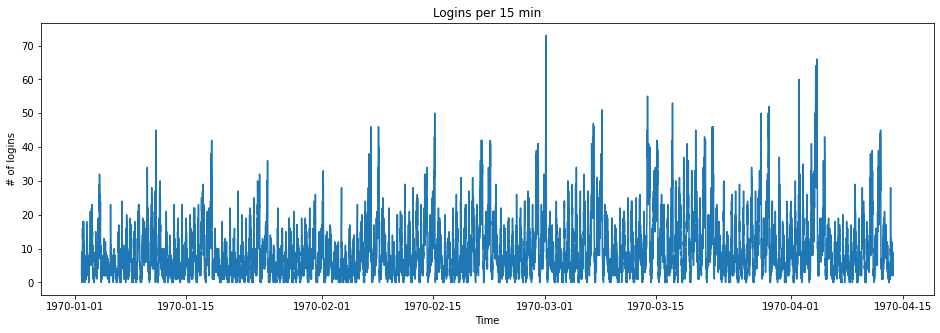

In [9]:
plt.figure(figsize=(16, 5))
plt.xlabel('Time')
plt.ylabel('# of logins')
plt.title('Logins per 15 min')
plt.plot(logins15.index, logins15['count'])

Looks like there is a pattern. Let's investigate further

<ipython-input-10-6fccdce7cf98>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(x_formatter)


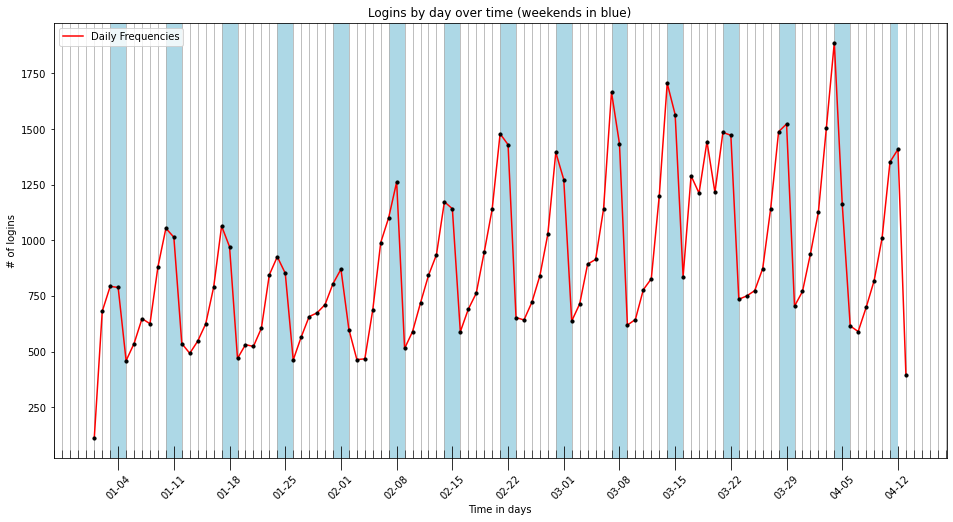

In [10]:
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FixedLocator, FixedFormatter

#bin data in various ways
logins_by_day = logins.resample('D').sum()

#start plot
fig, ax = plt.subplots(figsize= (16, 8))

#find weekend indices
def find_weekend_indices(datetime_array):
    indices = []
    for i in range(len(datetime_array)):
        if datetime_array[i].weekday() >= 5:
            indices.append(i)
    return indices

weekend_indices = find_weekend_indices(logins_by_day.index)

#highlight weekends
def highlight_datetimes(df, indices, ax):
    i = 0
    while i < len(indices)-1:
        ax.axvspan(df.index[indices[i]], df.index[indices[i] + 1], facecolor='lightblue', edgecolor='none', alpha=1)
        i += 1
highlight_datetimes(logins_by_day, weekend_indices, ax)

x_formatter = FixedFormatter(logins_by_day.index.strftime('%m-%d').tolist()[3::7])
x_locator = FixedLocator(range(3, len(logins_by_day), 7))

ax.set_xlabel('Time in days')
ax.set_ylabel('# of logins')
ax.set_title('Logins by day over time (weekends in blue)')
ax.xaxis.set_major_formatter(x_formatter)
ax.xaxis.set_major_locator(x_locator)
ax.tick_params(which='major', axis='x', direction='inout', length=24, labelrotation=45)
ax.xaxis.set_minor_locator(AutoMinorLocator(7))
ax.tick_params(which='minor', axis='x', direction='in', length=8)
ax.plot(logins_by_day.index, logins_by_day['count'],color='red', label='Daily Frequencies')
ax.grid(which='minor')
ax.legend(loc='upper left')
ax.scatter(logins_by_day.index, logins_by_day['count'], zorder=3, s=10, color='black')


Looks like Mondays tend to have the lowest number of logins per day with a steady increase, peaking on Saturday. 

### Hourly trends by day of week

In [11]:
# resample by hour
hourly_logins = logins.resample('H').sum()
# New day of week column. Monday=0, Sunday=6
day_of_week = list(hourly_logins.index.dayofweek)
hourly_logins['day_of_week'] = day_of_week
# column for hour on a 24 hour clock
hourly_logins['hour'] = [time.hour for time in hourly_logins.index]

In [12]:
hourly_logins

,count,day_of_week,hour
login_time,,,
1970-01-01 20:00:00,24,3,20
1970-01-01 21:00:00,9,3,21
1970-01-01 22:00:00,21,3,22
1970-01-01 23:00:00,58,3,23
1970-01-02 00:00:00,53,4,0
...,...,...,...
1970-04-13 14:00:00,32,0,14
1970-04-13 15:00:00,19,0,15
1970-04-13 16:00:00,22,0,16


In [13]:
hourly_logins = pd.pivot_table(hourly_logins, values = 'count', index = 'hour', columns = 'day_of_week', aggfunc=np.mean)
hourly_logins = hourly_logins.rename(columns = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})
hourly_logins_stacked = hourly_logins.stack(level=['day_of_week'])
hourly_logins_stacked.name = 'average_num_logins'
hourly_logins_stacked =  hourly_logins_stacked.reset_index()

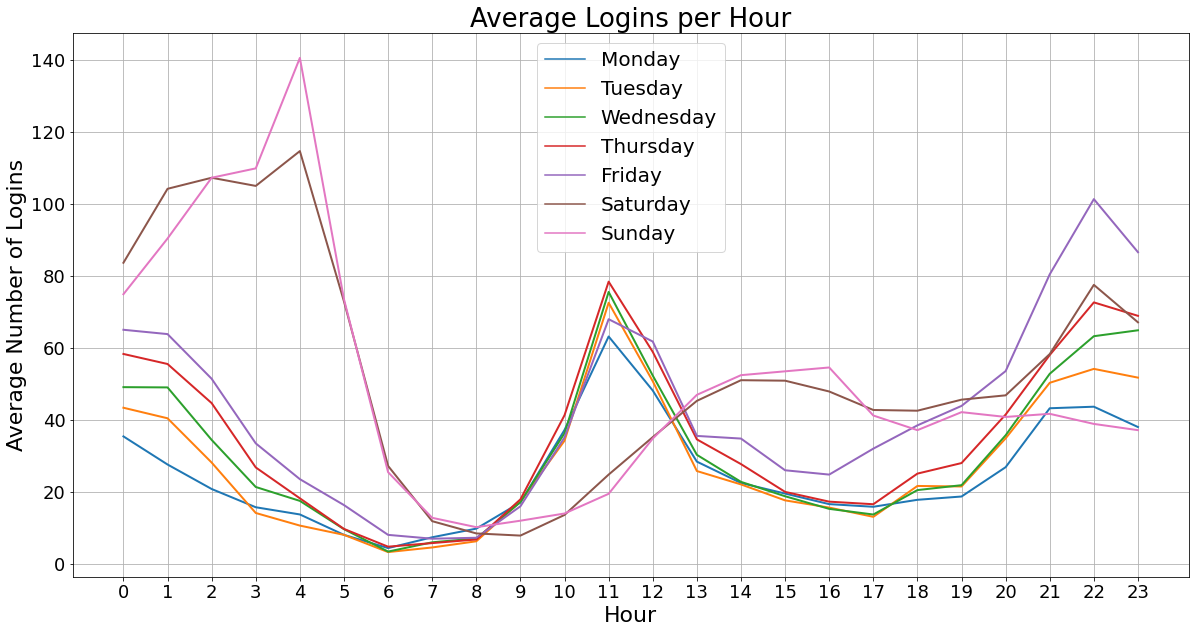

In [14]:
plt.figure(figsize=(20,10))
sns.lineplot(x='hour', y='average_num_logins', data=hourly_logins_stacked, 
            hue='day_of_week', legend=True, linewidth=2.0)
plt.xticks(range(24), range(24))
plt.gca()
plt.title('Average Logins per Hour', fontsize = 26)
plt.xlabel('Hour', fontsize = 22)
plt.ylabel('Average Number of Logins', fontsize = 22)
plt.tick_params(labelsize=18)
plt.grid()
plt.legend(loc='best', fontsize=20)

The graph shows the highest rate of logins occurs in the very early morning on weekends. The lowest is from about 0600 to 0900. The peaks for the weekdays are about 1100 and a more varied peak at 2200, particularly on Friday. 

### Part 2 ‐ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

1) What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

2) Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:

a) how you will implement the experiment

b) what statistical test(s) you will conduct to verify the significance of the
observation

c) how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

Note: The two cities of Gotham and Metropolis are not in the provided dataset; however, you do
not need this information to answer Part 2.

### Answers
1) 
I would choose the change in number of vehicles that use the bridge during the weekdays as a key measure of success. If the proposed experiment works, we should expect to see an increase in bridge crossings into Metropolis during the day and an increase in bridge crossings into Gotham at night. We can just choose one, because with an increase in bridge crossings into Metropolis during the day, we can reasonably assume an increase going the other direction at night. 

2) 
a) The null hypothesis is there will be no difference in the mean number of cars crossing the bridge to go into Metropolis during weekdays between 6am and 7pm. We will compare 4 weeks of data before the reimbursement plan and 4 weeks after the plan goes into effect. 

The alternative hypothesis is that there will be an increase in the mean number of cars crossing the bridge into Metropolis on weekdays between 6am and 7pm when comparing 4 weeks of data before the reimbursement plan and 4 weeks after the plan goes into effect. 

b) I would choose a two sample t-Test to compare the mean daytime bridge crossing into Metropolis of the most recent 4 weeks (20 weekdays total) to the 4 weeks following reimbursement implementation. *If we have a complete historical record of bridge crossings (i.e. we know the population variance) we could use a Z-test. 

c) If the p-value is less than 0.05 then we can reject the null hypothesis and recommend the reimbursement program. If the p-value is greater than 0.05 then we would fail to reject the null hypothesis, and therefor recommend a different approach. 



### Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice).

Data description

● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYYMMDD’

● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

● surge_pct: the percent of trips taken with surge multiplier > 1

● avg_surge: The average surge multiplier over all of this user’s trips

● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE
otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekday

### Load and explore the data

In [15]:
rider_data = pd.read_json('ultimate_data_challenge.json')

In [16]:
rider_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [17]:
rider_data.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

### Clean the data

In [18]:
rider_data['signup_date'] = pd.to_datetime(rider_data['signup_date'])
rider_data['last_trip_date'] = pd.to_datetime(rider_data['last_trip_date'])

In [19]:
# make new category of active_status if the rider has been "Active" in the past 30 days
active_30 = rider_data['last_trip_date'].max() - pd.Timedelta('30 days')
rider_data['active_status'] = (rider_data['last_trip_date'] > active_30).astype('int')

We need to convert the categorical data

In [20]:
rider_data['city'].value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [21]:
conv_city = pd.get_dummies(rider_data['city'])
rider_data = pd.concat((conv_city, rider_data), axis=1).drop(['city'], axis=1)
conv_phone = pd.get_dummies(rider_data['phone'])
rider_data = pd.concat((conv_phone, rider_data), axis=1).drop(['phone'], axis=1)

Check null values

In [22]:
rider_data.isnull().sum()

Android                      0
iPhone                       0
Astapor                      0
King's Landing               0
Winterfell                   0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
active_status                0
dtype: int64

In [23]:
len(rider_data[rider_data['avg_rating_of_driver'].isnull()]), len(rider_data[rider_data['avg_rating_of_driver'].notnull()])

(8122, 41878)

The number of null values for avg_rating_of_driver is quite a large percentage of our overall, and might be an important featuer itself. let's make a new category "left_rating"

In [24]:
rider_data['left_rating'] = 0
for row in range(len(rider_data)):
    if rider_data.iloc[row]['avg_rating_of_driver'] >= 0:
        rider_data.at[row, 'left_rating'] = 1

rider_data = rider_data[['Android', 'iPhone', 'Astapor', "King's Landing", 'Winterfell',
       'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'left_rating', 'avg_surge', 'last_trip_date', 'surge_pct', 'ultimate_black_user',
       'weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'active_status']]        

fill the missing values with the mean

In [25]:
rider_data['avg_rating_of_driver'].fillna(value=rider_data['avg_rating_of_driver'].mean(), inplace=True)
rider_data['avg_rating_by_driver'].fillna(value=rider_data['avg_rating_by_driver'].mean(), inplace=True)

In [26]:
rider_data.isnull().sum()

Android                   0
iPhone                    0
Astapor                   0
King's Landing            0
Winterfell                0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
left_rating               0
avg_surge                 0
last_trip_date            0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
active_status             0
dtype: int64

split into active and inactive

In [27]:
active = rider_data[rider_data['active_status'] == 1]
inactive = rider_data[rider_data['active_status'] == 0]

In [28]:
print('There are {} active users.'.format(len(active)))
print('There are {} inactive users.'.format(len(inactive)))
print('{} percent of users were retained.'.format(len(active)/(len(inactive)+len(active))*100))

There are 18310 active users.
There are 31690 inactive users.
36.620000000000005 percent of users were retained.


In [29]:
active.describe()

,Android,iPhone,Astapor,King's Landing,Winterfell,trips_in_first_30_days,avg_rating_of_driver,left_rating,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active_status
count,18310.000000,18310.000000,18310.000000,18310.000000,18310.000000,18310.000000,18310.000000,18310.000000,18310.000000,18310.000000,18310.000000,18310.000000,18310.000000,18310.0
mean,0.160677,0.832223,0.219661,0.344457,0.435882,3.349590,4.594066,0.914364,1.073720,9.128165,62.214604,5.118977,4.763149,1.0
std,0.367243,0.373678,0.414029,0.475204,0.495885,5.020615,0.514611,0.279834,0.163183,15.489344,29.068319,4.627946,0.324265,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.0
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.400000,1.000000,1.000000,0.000000,45.500000,2.560000,4.700000,1.0
50%,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,4.700000,1.000000,1.000000,0.000000,65.200000,3.730000,4.800000,1.0
75%,0.000000,1.000000,0.000000,1.000000,1.000000,4.000000,5.000000,1.000000,1.090000,13.300000,85.700000,5.880000,5.000000,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,125.000000,5.000000,1.000000,4.500000,100.000000,100.000000,160.960000,5.000000,1.0


In [30]:
inactive.describe()

,Android,iPhone,Astapor,King's Landing,Winterfell,trips_in_first_30_days,avg_rating_of_driver,left_rating,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active_status
count,31690.000000,31690.000000,31690.000000,31690.000000,31690.000000,31690.000000,31690.000000,31690.000000,31690.000000,31690.000000,31690.000000,31690.000000,31690.00000,31690.0
mean,0.381193,0.610413,0.394825,0.120637,0.484538,1.659167,4.605889,0.793184,1.075367,8.688548,60.181597,6.188478,4.78683,0.0
std,0.485687,0.487664,0.488821,0.325711,0.499769,2.661903,0.592092,0.405029,0.250219,22.132211,40.985698,6.213027,0.50254,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.00000,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.500000,1.000000,1.000000,0.000000,16.700000,2.320000,4.80000,0.0
50%,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,4.800000,1.000000,1.000000,0.000000,66.700000,4.030000,5.00000,0.0
75%,1.000000,1.000000,1.000000,0.000000,1.000000,2.000000,5.000000,1.000000,1.000000,0.000000,100.000000,7.770000,5.00000,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,73.000000,5.000000,1.000000,8.000000,100.000000,100.000000,129.890000,5.00000,0.0


### Visualizations

In [31]:
active_stats = active.describe()
active_stats = active_stats.loc['mean':'std']
inactive_stats = inactive.describe()
inactive_stats = inactive_stats.loc['mean':'std']

In [32]:
inactive_stats

,Android,iPhone,Astapor,King's Landing,Winterfell,trips_in_first_30_days,avg_rating_of_driver,left_rating,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active_status
mean,0.381193,0.610413,0.394825,0.120637,0.484538,1.659167,4.605889,0.793184,1.075367,8.688548,60.181597,6.188478,4.78683,0.0
std,0.485687,0.487664,0.488821,0.325711,0.499769,2.661903,0.592092,0.405029,0.250219,22.132211,40.985698,6.213027,0.50254,0.0


In [33]:
active_stats = active_stats[['trips_in_first_30_days', 'avg_rating_of_driver', 'left_rating', 'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver']]
inactive_stats = inactive_stats[['trips_in_first_30_days', 'avg_rating_of_driver', 'left_rating', 'avg_surge', 'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver']]

In [34]:
active_stats['active_status'] = 1
inactive_stats['active_status'] = 0

<ipython-input-34-de1da71d93cb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inactive_stats['active_status'] = 0


In [35]:
act_mean = pd.DataFrame(active_stats.loc['mean'].T)
inact_mean = pd.DataFrame(inactive_stats.loc['mean'].T)
act_std = pd.DataFrame(active_stats.loc['std'].T)
inact_std = pd.DataFrame(inactive_stats.loc['std'].T)

In [36]:
act_mean = act_mean.rename({'mean': 'active_mean'}, axis=1)
inact_mean = inact_mean.rename({'mean': 'inactive_mean'}, axis=1)
act_std = act_std.rename({'std': 'active_std'}, axis=1)
inact_std = inact_std.rename({'std': 'inactive_std'}, axis=1)

In [37]:
stats_df = act_mean
stats_df['inactive_mean'] = inact_mean['inactive_mean']
stats_df['active_std'] = act_std['active_std']
stats_df['inactive_std'] = inact_std['inactive_std']

In [38]:
stats_df

,active_mean,inactive_mean,active_std,inactive_std
trips_in_first_30_days,3.349590,1.659167,5.020615,2.661903
avg_rating_of_driver,4.594066,4.605889,0.514611,0.592092
left_rating,0.914364,0.793184,0.279834,0.405029
avg_surge,1.073720,1.075367,0.163183,0.250219
surge_pct,9.128165,8.688548,15.489344,22.132211
weekday_pct,62.214604,60.181597,29.068319,40.985698
avg_dist,5.118977,6.188478,4.627946,6.213027
avg_rating_by_driver,4.763149,4.786830,0.324265,0.502540
active_status,1.000000,0.000000,1.000000,0.000000


Text(0.5, 1.0, 'Mean for Active vs Inactive Users')

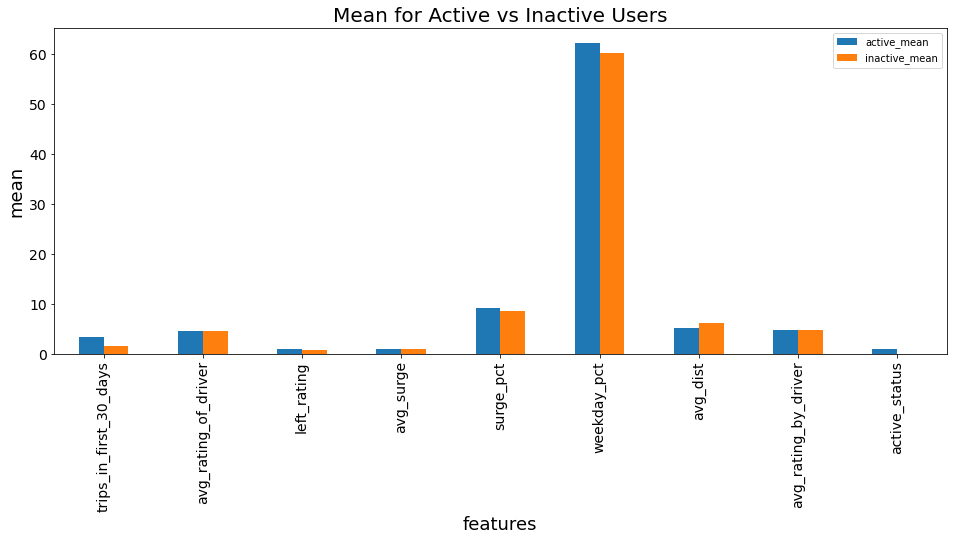

In [39]:
stats_df[['active_mean', 'inactive_mean']].plot(kind='bar', figsize=(16,6), fontsize=14)
plt.xlabel('features', fontsize= 18)
plt.ylabel('mean', fontsize=18)
plt.title('Mean for Active vs Inactive Users', fontsize=20)

We might want to standardize the data

Text(0.5, 1.0, 'std for Active vs Inactive Users')

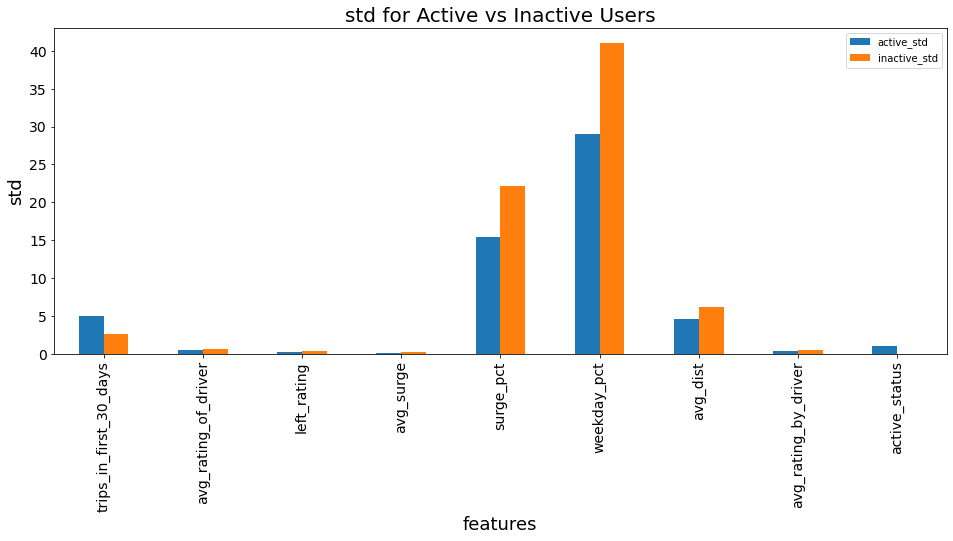

In [40]:
stats_df[['active_std', 'inactive_std']].plot(kind='bar', figsize=(16,6), fontsize=14)
plt.xlabel('features', fontsize= 18)
plt.ylabel('std', fontsize=18)
plt.title('std for Active vs Inactive Users', fontsize=20)

# Train test split and Standardize the data

In [43]:
rider_data.columns

Index(['Android', 'iPhone', 'Astapor', 'King's Landing', 'Winterfell',
       'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'left_rating', 'avg_surge', 'last_trip_date', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'active_status'],
      dtype='object')

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

feature_cols = ['Android', 'iPhone', 'Astapor', "King's Landing", 'Winterfell',
       'trips_in_first_30_days', 'avg_rating_of_driver', 'left_rating',
       'avg_surge', 'surge_pct', 'ultimate_black_user',
       'weekday_pct', 'avg_dist', 'avg_rating_by_driver']

X = rider_data[feature_cols]
y = rider_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [46]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=feature_cols)
X_test = pd.DataFrame(X_test, columns=feature_cols)

In [47]:
X_train.mean(), X_train.std(ddof=0)

(Android                  -1.748581e-15
 iPhone                   -2.629760e-15
 Astapor                   1.771442e-16
 King's Landing           -1.318619e-15
 Winterfell                3.939959e-17
 trips_in_first_30_days    5.875063e-16
 avg_rating_of_driver      7.509726e-16
 left_rating              -1.185277e-15
 avg_surge                 1.193922e-15
 surge_pct                -3.113418e-15
 ultimate_black_user       1.051864e-15
 weekday_pct               4.975220e-16
 avg_dist                 -5.603222e-17
 avg_rating_by_driver      1.316138e-15
 dtype: float64,
 Android                   1.0
 iPhone                    1.0
 Astapor                   1.0
 King's Landing            1.0
 Winterfell                1.0
 trips_in_first_30_days    1.0
 avg_rating_of_driver      1.0
 left_rating               1.0
 avg_surge                 1.0
 surge_pct                 1.0
 ultimate_black_user       1.0
 weekday_pct               1.0
 avg_dist                  1.0
 avg_rating_by_drive

<AxesSubplot:>

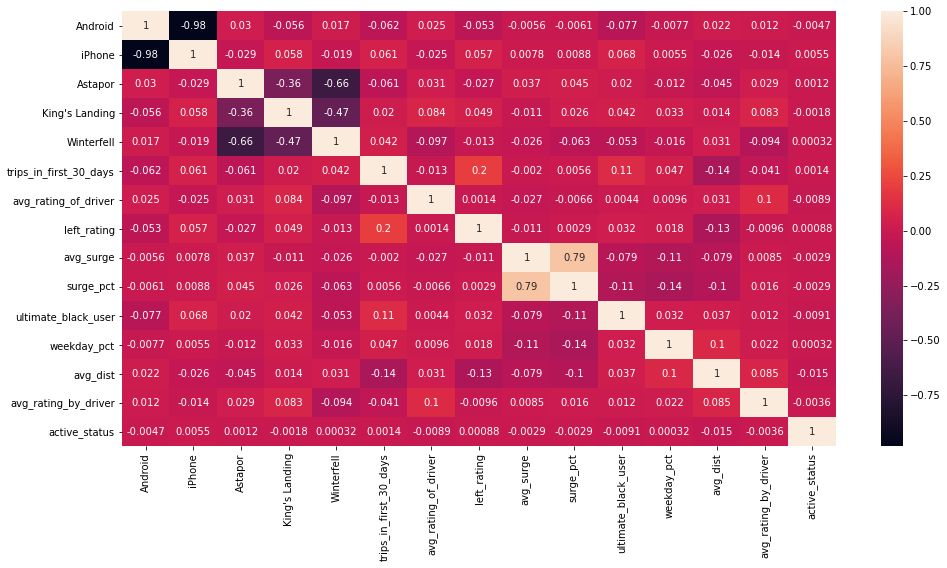

In [48]:
plt.figure(figsize=(16,8))
sns.heatmap(X_train.assign(active_status = y_train).corr(), annot=True)

avg_surge and surge_pct are highly correlated. We will leave them in for now. 

In [49]:
y_train.value_counts(), y_test.value_counts()

(0    23766
 1    13734
 Name: active_status, dtype: int64,
 0    7924
 1    4576
 Name: active_status, dtype: int64)

Our dataset isn't too imabalanced, so we don't need to worry about using sampling techniques

# XGBoost vs Logistic Regression vs Random Forest

In [50]:
from xgboost import XGBClassifier, plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

GridSearch = pd.DataFrame()


XGB_params = {
    'max_delta_step':[0,0.05],
    'scale_pos_weight':[0.95, 0.9],
    'subsample':[1,0.8],
    'learning_rate': [0.25, 0.2, 0.1],
    'min_child_weight':[0,1,2],
    'gamma':[1, 2, 3]
    }

LR_params = {
        'penalty': ['l2', 'none'],
        'C': [0.001,0.01,0.1,1,10,100,1000],
        'solver':['newton-cg', 'lbfgs', 'sag', 'saga']
    }

RF_params = {
        'n_estimators': [80,100,150,200,300, 500],
        'criterion': ['gini', 'entropy']
    }


In [51]:
%%capture --no-display

XGB_class = XGBClassifier(objective= 'binary:logistic', random_state=42, silent =1, n_estimators=10, max_depth=8)
XGB_grid_search = GridSearchCV(param_grid=XGB_params, estimator=XGB_class, cv=5, scoring='accuracy')
XGB_grid_search.fit(X_train, y_train)
XGB_series = pd.Series([XGB_grid_search.best_params_,
                   XGB_grid_search.best_score_])
XGB_series.name = 'XGBClassifier'
GridSearch = GridSearch.append(XGB_series)

In [52]:
%%capture --no-display

LR_class = LogisticRegression()
LR_grid_search = GridSearchCV(param_grid= LR_params, estimator= LR_class, scoring='accuracy' , cv=5)
LR_grid_search.fit(X_train, y_train)

LR_series = pd.Series([LR_grid_search.best_params_,
                       LR_grid_search.best_score_])
LR_series.name = 'LogisticRegression'
GridSearch = GridSearch.append(LR_series)

In [53]:
RF_class = RandomForestClassifier()
RF_grid_search = GridSearchCV(param_grid= RF_params, estimator= RF_class, scoring='accuracy' , cv=5)
RF_grid_search.fit(X_train, y_train)

RF_series = pd.Series([RF_grid_search.best_params_,
                       RF_grid_search.best_score_])
RF_series.name = 'RandomForest'
GridSearch = GridSearch.append(RF_series)

In [54]:
GridSearch = GridSearch.rename(columns={0: 'optimal_params', 1: 'best_score'})

In [55]:
GridSearch

,optimal_params,best_score
XGBClassifier,"{'gamma': 3, 'learning_rate': 0.25, 'max_delta...",0.790667
LogisticRegression,"{'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}",0.729813
RandomForest,"{'criterion': 'gini', 'n_estimators': 100}",0.766080


We can see the best score is with XGBClassifier

In [56]:
opt_params = GridSearch['optimal_params'][0]

In [57]:
opt_params

{'gamma': 3,
 'learning_rate': 0.25,
 'max_delta_step': 0,
 'min_child_weight': 0,
 'scale_pos_weight': 0.95,
 'subsample': 0.8}

# Final Model

In [115]:
%%capture --no-display
#let's see how the model does on the unoptimized training set
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, RocCurveDisplay, confusion_matrix, classification_report, auc, plot_roc_curve

XGB_unopt_clf = XGBClassifier(random_state=42, silent =1, n_estimators=10, max_depth=8)
XGB_unopt_clf.fit(X_train, y_train)

y_unopt_pred = XGB_unopt_clf.predict(X_train)

score_unopt_train = accuracy_score(y_train, y_unopt_pred)

# now the unoptimzed test set

XGB_unopt_clf = XGBClassifier(random_state=42, silent =1, n_estimators=10, max_depth=8)
XGB_unopt_clf.fit(X_train, y_train)

y_unopt_pred = XGB_unopt_clf.predict(X_test)

score_unopt_test = accuracy_score(y_test, y_unopt_pred)


In [121]:
%%capture --no-display
# optimized training set
XGB_clf = XGBClassifier(**opt_params)
XGB_clf.fit(X_train, y_train)

y_pred = XGB_clf.predict(X_train)

score_train = accuracy_score(y_train, y_pred)

# optimized test set
XGB_clf = XGBClassifier(**opt_params)
XGB_clf.fit(X_train, y_train)

y_pred = XGB_clf.predict(X_test)
y_prob = XGB_clf.predict_proba(X_test)[:,1]
cm_XGB = confusion_matrix(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
score_test = accuracy_score(y_test, y_pred)


In [123]:
print("The resulting accuracy of the UNOPTIMIZED classifier on the TRAINING set is {}.".format(round(score_unopt_train,4)))
print("The resulting accuracy of the OPTIMIZED classifier on the TRAINING set is {}.".format(round(score_train,4)))
print("The resulting accuracy of the UNOPTIMIZED classifier on the TEST set is {}.".format(round(score_unopt_test,4)))
print("The resulting accuracy of the OPTIMIZED classifier on the TEST set is {}.".format(round(score_test,4)))

The resulting accuracy of the UNOPTIMIZED classifier on the TRAINING set is 0.8183.
The resulting accuracy of the OPTIMIZED classifier on the TRAINING set is 0.8306.
The resulting accuracy of the UNOPTIMIZED classifier on the TEST set is 0.7876.
The resulting accuracy of the OPTIMIZED classifier on the TEST set is 0.7943.


The optimized params performed better on both the training and test data.

In [124]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84      7924
           1       0.74      0.67      0.70      4576

    accuracy                           0.79     12500
   macro avg       0.78      0.77      0.77     12500
weighted avg       0.79      0.79      0.79     12500



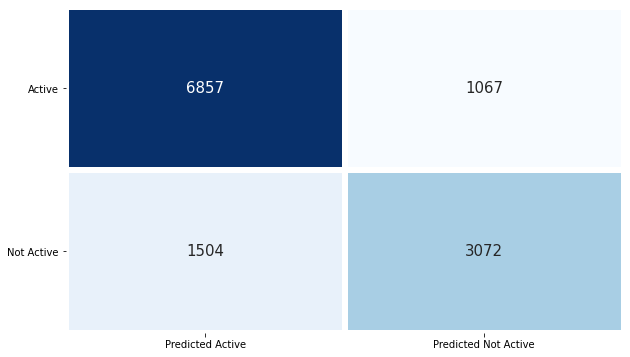

In [125]:
plt.figure(figsize = (10, 6))
sns.heatmap(cm_XGB, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['Active', 'Not Active'], xticklabels = ['Predicted Active', 'Predicted Not Active'])
plt.yticks(rotation = 0)
plt.show()

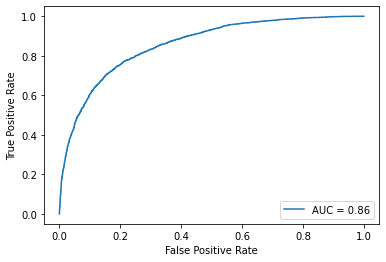

In [126]:
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

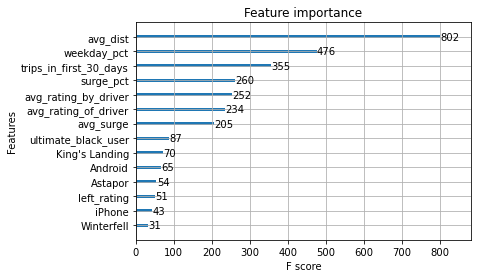

In [127]:
plot_importance(XGB_clf)

### The optimized parameters produced the best model for XGBoost, resulting 79.43% accuracy and 0.86 AUC. The most important features in predicting rider retention are avg_dist, weekday_pct, and trips_in_first_30 days.